# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl 
import plotly.plotly as py
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# A look into a sample data (using pandas)

In [2]:
data = pd.read_fwf('test.txt', header=None, names = ["x", "y", "u"], widths=[21,30,35])
data.shape

(5000, 3)

In [3]:
data.head()

,x,y,u
0,5.000000e-07,5.000000e-07,10.414622
1,1.500000e-06,5.000000e-07,9.026352
2,2.500000e-06,5.000000e-07,7.614043
3,3.500000e-06,5.000000e-07,6.187198
4,4.500000e-06,5.000000e-07,5.474294


Data has three rows, x, y, and u. x and y mark the 2D locations across the channel and u marks the velocity magnitude at each node. The locations on the mesh are forced to remain uniform, therefore, x and y are identical for all datasets. This is done by algorithms in the meshing part not included here. 'u' is constructed as sqrt(u_x^2 + u_y^2). For simplicity and in a effort of lowering computation and memory limitations, the rest of values have not been recorded here.

In [4]:
data.dtypes

x    float64
y    float64
u    float64
dtype: object

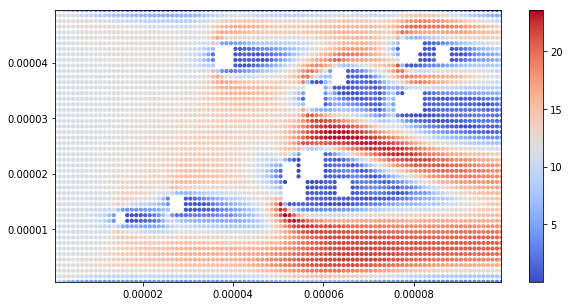

In [5]:
plt.figure(figsize=(10, 5))
cm = mpl.cm.get_cmap('coolwarm')
sc = plt.scatter(data.x, data.y, c=data.u, vmin=min(data.u), vmax=max(data.u), s= 10, cmap=cm) 
plt.colorbar(sc) 
plt.xlim(min(data.x), max(data.x))
plt.ylim(min(data.y), max(data.y))
plt.show() 

Problem consists of a 2D viscous flow in a microchannel. The left side is velocity inlet boundary conditions, the right is pressure outlet at atmospheric gauge pressure, and the upper and lower  boundaries are walls. Inside the domain, a random number of objects are placed with random sizes and at random locations. The inlet velocity has been chosen as a constant on part of the dataset and is also chosen randomly on a portion of the data (difference marked in the name of the dataset files).

nodes inside the walls are marked by NULLs in the velocity vector, 'u'

In [6]:
sum(data.u.isnull())

165

In [7]:
data['walls'] = data.u
data.walls[~data.walls.isnull()] = 0
data.walls[ data.walls.isnull()] = 1

# velocity is zero inside the walls
data.u[data.u.isnull()] = 0

In [8]:
x = data.x.values.reshape(50,100)
y = data.y.values.reshape(50,100)
u = data.u.values.reshape(50,100)
walls = data.walls.values.reshape(50,100)

In [9]:
x.shape

(50, 100)

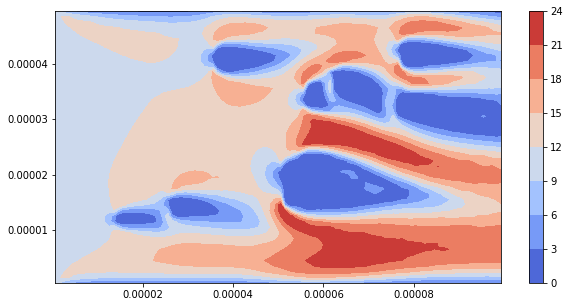

In [10]:
plt.figure(figsize=(10, 5))
cm = mpl.cm.get_cmap('coolwarm')
g = plt.contourf(x, y, u, cmap=cm)
g = plt.colorbar(g)

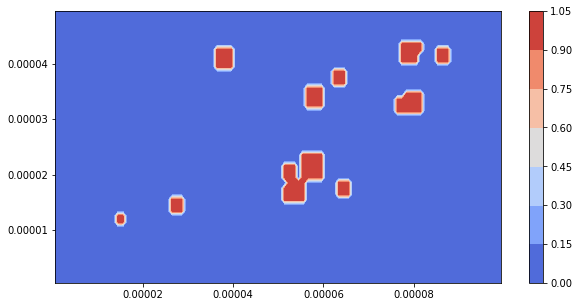

In [11]:
plt.figure(figsize=(10, 5))
cm = mpl.cm.get_cmap('coolwarm')
g = plt.contourf(x, y, walls, cmap=cm)
g = plt.colorbar(g)

# Loading data using TensorFlow data API (using tf.data) 

To make data more accessible in TensorFlow, especially to benefit later from batch processing pipeline capabilities of TensorFlow, tf.data API is used as an alternative to pandas for data handeling.

In [82]:
# test: converting a pandas data array into tf tensor
u_tf = tf.convert_to_tensor(u)

u_tf.shape, u.shape

(TensorShape([Dimension(50), Dimension(100)]), (50, 100))

Accessing tensor members needs to be done inside a session run:

In [102]:
u_tf[0,0:5], u[0,0:5] # does not return values

(<tf.Tensor 'strided_slice_28:0' shape=(5,) dtype=float64>,
 array([10.41462229,  9.02635235,  7.6140426 ,  6.18719831,  5.4742936 ]))

In [107]:
sess = tf.Session()
sess.run(u_tf[0,0:5])

array([10.41462229,  9.02635235,  7.6140426 ,  6.18719831,  5.4742936 ])

In [111]:
def splitter(x):
    out = tf.string_split([x], delimiter=' ').values[2]
    return tf.string_to_number(out, tf.float64)

dataset = tf.data.TextLineDataset("test.txt")

dataset = dataset.map(lambda x: splitter(x) )

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()


sess = tf.Session();

try:
    while 1:
        print(sess.run(next_element))
except tf.errors.OutOfRangeError:
    print('EOF reached...')
finally:
    print('Done!')
        

10.414622292733211
9.026352345955038
7.614042600850346
6.187198314449688
5.474293601888786
4.863721971306515
4.524971982892988
4.242155115568993
4.015794018276705
3.8819715213194663
3.7832124569710928
3.768004560038572
3.7614745976711452
3.777093660886643
3.7796119032379103
3.7667781281332733
3.7674863821354077
3.7736873586455104
3.781625293673742
3.781529343823526
3.7489676675809442
3.7256344368097234
3.7136403402282947
3.7096115898502275
3.709123378061554
3.7059116674796115
3.7012988406508494
3.69118755785441
3.6770784166593247
3.6576747856278216
3.6414967921105386
3.6269949915517965
3.595923039199216
3.5675250191019168
3.559367105330088
3.563757194797329
3.5859442617141384
3.6045886303567563
3.6214472929838744
3.68098229471262
3.7520716257787123
3.862545417621987
3.985975781472589
4.129304792766345
4.306085098509405
4.501852329016162
4.718973411089784
4.938295708681717
5.150981022247771
5.378358531523188
5.629630698343643
5.850208548714897
6.052556819610713
6.1937409218529735
6.3209

13.64214948947135
13.542674514654745
13.529989973506469
13.450847742203308
13.281320333651673
13.175167466027693
13.044763776742728
13.044428856641776
13.025165944975988
12.864991114471776
12.748758648053807
12.759024132359807
12.778200780694977
12.759872673685429
13.031288762529556
13.30877737870306
13.67142113142831
14.124368323289042
14.763195546887285
15.479137334194593
16.325655139590133
17.146180190372796
17.89408558268681
18.642490888167433
19.293369341875486
19.836373514252884
20.33626301128182
20.7420879451255
21.13593181030308
21.340041245184384
21.426567923537533
21.47734983542736
21.510064017723277
21.472361939007364
21.522895722968503
21.505586173627318
21.44019901631248
21.36265927962832
21.351600991905265
21.343361934261928
21.383763840833915
21.31599688301612
21.03931729495199
20.98129875858997
21.01389448663064
20.93882713391231
20.988226668001193
20.79920445931898
20.6965148148073
20.498977795969907
20.692033624095178
20.866822423961366
20.564637761562793
20.307410011

13.834376415730963
13.720622891131475
13.528247108173458
13.15709774914044
12.636002852562251
12.094141879403505
11.348974878079288
10.628701865830516
11.386736295225356
9.514981833501668
6.731124855072766
6.10049301119008
6.184461359173018
6.68908855396486
7.3833589586042025
7.949036847441461
8.507480673463288
9.095047831631282
9.35617954686854
9.44169601915152
10.149489699921737
10.519209150877979
10.824353363083441
10.98666823572723
11.403683628591892
11.57189009812886
12.107180815149231
12.158828529592853
12.358401818505019
12.289720446778656
12.222309360806426
11.990140114740976
11.956130400854386
9.554142027835972
nan
nan
nan
nan
nan
0.3763114315606685
0.8732871837538546
1.1965873657447714
1.3750263232285236
1.2719825919147763
0.8146166575734108
0.22424251065341624
nan
nan
nan
0.5785959336167644
1.0843658088462662
1.626697793172733
2.2183922900415203
2.62875144499804
2.940924162132343
2.7140647455833884
2.2153964340865557
1.6232328877682702
0.76666682466177
0.22404018439958284
0.

22.385500948944024
22.25165189275473
21.346437191935454
20.647744135826482
19.670914019517948
18.845910175526175
18.0899367569991
17.338682122876197
16.564948082894226
15.679610226579369
15.107293033094628
14.451271402190958
14.070132366209425
13.407354844155691
12.942550835206815
12.605313890750459
12.08003419990624
11.924210112323085
11.559459839171213
11.331320448555225
11.196469210439751
11.038031219897169
10.649088954747143
10.061972260301097
11.112585690368054
11.119874629319906
11.131387690044964
11.154475494378065
11.180352668624765
11.218166167760184
11.263654307235162
11.316011306716522
11.382600420081344
11.449230803558585
11.530105995496346
11.617544224509123
11.709474841829511
11.804679082396971
11.897073139627313
11.988409094663423
12.094228172627753
12.19007124121985
12.28470845459607
12.380514050389309
12.483707669966412
12.593025578971755
12.711393129768712
12.827034100289975
12.94632618659476
13.082729792420078
13.219148461324236
13.347768345903507
13.463883255751247


16.291671119279464
15.124770184846405
13.92692749892961
12.582336773180138
11.236831427474268
9.813482038636353
8.522717328791
7.819569780277686
8.609534251792894
10.385161016499405
9.300556937953063
6.5170714326256896
4.448322512238195
3.0696817382068025
2.1828936652357815
1.5763957142902143
1.2301034067525922
0.9460058515264372
0.6031660413159147
0.20771440552406992
0.1809481124502114
0.4219365188457128
0.7686794827200389
1.041328362831368
1.2956256242872217
1.5742599214094595
1.7785577912851689
2.045493125447666
2.396046094448705
2.3641742358967406
2.433001925594099
2.5410652513061804
1.8973609053622702
1.0468557050841865
11.112048000837417
11.118154551171864
11.128769834288025
11.14996174236507
11.170847706188944
11.20368546825029
11.238960329394974
11.280846525946773
11.326964248944833
11.375549101402136
11.428744265469136
11.484986057921185
11.543941152701754
11.606873959766821
11.675586820624847
11.74432935617806
11.811423714295882
11.877712784520234
11.943310683281615
12.012265

18.687807885761213
17.749938023016576
17.186491381892083
16.414906131075124
16.030244273668895
15.188077879575618
14.472699530366718
13.894304534445508
13.442828145321501
12.640603062036636
12.422198544429387
12.321150726251066
11.313152370967895
11.349106502738264
11.412082726310118
10.771088471333702
10.343383601617514
10.38341969838203
11.113957673401028
11.123940523677375
11.136362463505204
11.165103024068921
11.198397197153394
11.231037554982791
11.270014443297402
11.319476279829214
11.366660490199694
11.413310998452777
11.462788128489285
11.50841063788047
11.55683758307515
11.596859659742137
11.640014907353876
11.683432914069561
11.720403065642435
11.757839819764209
11.781175326597678
11.795361554813843
11.81059631604508
11.828320945071406
11.841495545263198
11.827948053786699
11.815630635430505
11.782535213684444
11.748490388412804
11.694370350615234
11.633321374341676
11.537451218246296
11.475145463940528
11.459368571834785
11.55182496243378
11.968511692789777
13.16516198324059

5.455494785464964
6.970871748147019
8.688928554459894
10.348995955483602
11.660345398870684
12.983126833180071
14.158491413635828
15.154592987908808
16.142006692377887
17.265123609572086
18.46423467939807
19.227557897013934
19.560711728928503
19.530851778962006
19.31741664080609
19.077007520118666
18.454395707555037
17.872996468768495
17.155174840926566
16.41278561813321
15.343547117857915
13.78451544540989
11.61553948942769
8.891118554519794
5.757923632665108
nan
nan
nan
nan
0.20915002148326398
0.6194408126289431
1.0619877107526008
0.6988844312766226
nan
nan
nan
0.25049269290285636
0.5819443008775734
0.3019050583500493
0.6360875679005368
2.0083376396441337
2.9991166673046648
4.298937843844858
4.315661438914905
5.298625740287408
5.2919549812116955
6.115194891175991
6.868814617983624
11.116975488650718
11.146418761334116
11.185404449946656
11.244112074735348
11.34008704504782
11.430374519154263
11.507509639960325
11.572327533430693
11.653751859694145
11.76667256253293
11.828440756335944

11.009539038641426
10.870053190796593
10.777988311567547
10.685091087671852
10.606640360412037
10.52221922221576
10.514804117216675
10.626544672912646
10.711615683760442
10.771953765458177
10.900550861236113
11.208557984655304
11.804173556430847
12.617373565448268
13.598325155649219
14.567805829061298
15.407862246131547
15.979493586532772
16.36591463933116
16.566056772559065
16.603856404107336
16.57078597069166
16.448783865592493
16.33992084468337
15.894598091083031
15.685722651790883
15.04251554031635
14.681201876701689
14.360421913878914
14.357122031765785
14.405105898446912
14.338731352499531
14.408287457295947
14.442277627594056
14.432236254253976
14.566672304140404
14.894216842522885
15.007970323491811
15.157088656342154
15.280344598463094
15.47800697938546
15.63005232993216
15.751975531705739
15.780844131893689
15.864514150742139
15.892853470589952
15.799081808359265
15.79451930398201
15.778155651136723
15.4874275330791
15.129569971233146
14.838153908194359
14.680381936741918
14.

In [15]:
tf.data.TFRecordDataset

filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(...)  # Parse the record into tensors.
dataset = dataset.repeat()  # Repeat the input indefinitely.
dataset = dataset.batch(32)
iterator = dataset.make_initializable_iterator()

# You can feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.

# Initialize `iterator` with training data.
training_filenames = ["/var/data/file1.tfrecord", "/var/data/file2.tfrecord"]
sess.run(iterator.initializer, feed_dict={filenames: training_filenames})

# Initialize `iterator` with validation data.
validation_filenames = ["/var/data/validation1.tfrecord", ...]
sess.run(iterator.initializer, feed_dict={filenames: validation_filenames})

TypeError: 'ellipsis' object is not callable

In [ ]:
dataset = tf.data.FixedLengthRecordDataset("test.txt", 3)

In [ ]:
dataset

In [ ]:
train_in = tf.data.FixedLengthRecordDataset('data/train.in', 3072)
train_out = tf.data.FixedLengthRecordDataset('data/train.out', 1)
train_data = tf.data.Dataset.zip((train_in, train_out)) \
        .map(mk_parse) \
        .shuffle(buf_size) \
        .batch(batch_size) \
        .repeat(epochs)

# Working with batch data files (10 files to start with)

In [ ]:
dir_path = "Samples/0.01/"
filenames = tf.gfile.ListDirectory(dir_path)
print(filenames)

The file naming convention is simple, the inlet velocity is added first followed by an underscrore and a random number. Therefore, '0.01_26086.txt' represents a flow inlet of 0.01. The choice of random number was due to the parallel data generation and added as a simple solution to avoid race condition and data overwriting.

In [ ]:
dir_path = "Samples/0.01/"
filenames = tf.gfile.ListDirectory(dir_path)
dataset = tf.data.Dataset.from_tensor_slices(filenames)
batched_dataset = dataset.batch(5)

iterator = batched_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

sess = tf.Session()
print(sess.run(next_element))
print(sess.run(next_element))

In [ ]:
dir_path = "Samples/0.01/"
filenames = tf.gfile.ListDirectory(dir_path)
dataset = (tf.data.Dataset.from_tensor_slices(filenames)
           .interleave(lambda x:
               tf.data.TextLineDataset(x).map(parse_fn, num_parallel_calls=1),
               cycle_length=4, block_length=16))

In [ ]:
record_defaults = [[0.0]] * 1
dataset = tf.contrib.data.CsvDataset('samples/11.0111_81050103.txt', record_defaults, header=True, select_cols=[3])

In [ ]:
value.shape